In [19]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from utils import ndcg, hr, flood_negative_samples
import json
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
from collections import Counter
import matplotlib.pyplot as plt
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import *
from torch.utils.tensorboard import SummaryWriter
from ncf.dataset import ItemDataset, ValidationDataset
from ncf.model import GMF, MLP, NeuMF, UserNeuMF, train_ncf, train_user_neu, load_pretrained_weights_neu_mf_from_path, evaluate_neu, evaluate_user_neu
from sklearn.model_selection import train_test_split
from torchsummaryX import summary
from hparams import Hparam
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import os
from sklearn.neighbors import NearestNeighbors

In [2]:
master = 'local[*]'
app_name = 'vk_2020_als'
sc = SparkContext(master, app_name)
spark = SparkSession.builder.master(master).appName(app_name).getOrCreate()

### Обработка пользователей

In [4]:
def parse_user(user):
    user_id = int(user[0])
    try:
        info_json = json.loads(user[1])
        age = info_json['age']
        country = info_json['country']
        gender = info_json['gender']
        playcount = info_json['playcount']
    except:
        age = 0
        country = 'Nan'
        gender = 'Nan'
        playcount = 0
    return (user_id, age, country, gender, playcount)
        


user_dataframe = spark.read.csv('../data/entities/users.idomaar', header=False, sep='\t')
user_dataframe = user_dataframe.drop('_c0', '_c2')
user_rdd = user_dataframe.rdd.map(parse_user)
user_dataframe = user_rdd.map(lambda row: Row(user_id=row[0], age=row[1], country=row[2], gender=row[3], playcount=row[4])).toDF()
user_dataframe.show(1)

+---+-------+------+---------+-------+
|age|country|gender|playcount|user_id|
+---+-------+------+---------+-------+
| 24|     US|     f|   221012|      1|
+---+-------+------+---------+-------+
only showing top 1 row



### Обработка треков

In [3]:
tracks_dataframe = spark.read.csv('../data/entities/tracks.idomaar', sep='\t', header=False)
tracks_dataframe.show(1)

+-----+---+---+--------------------+--------------------+
|  _c0|_c1|_c2|                 _c3|                 _c4|
+-----+---+---+--------------------+--------------------+
|track|  0| -1|{"duration":-1,"p...|{"artists":[{"typ...|
+-----+---+---+--------------------+--------------------+
only showing top 1 row



In [4]:
def parse_track(track):
    track_id = int(track[0])
    info_json = json.loads(track[1])
    
    duration = info_json['duration']
    duration = int(duration) if duration is not None else -1
    
    links_json = json.loads(track[2])
    artists = links_json['artists']
    # Проверкой было установлено, что для каждой записи указан только один артист (те len(artists) == 1)
    assert len(artists) == 1
    artist_id = artists[0]['id']
    
    tags = links_json['tags']
    # В некоторых треках вместо пустого листа стоит null
    if tags is None:
        tags = []
    else:
        tags = filter(lambda obj: obj['type'] == 'tag', tags)
        tags = list(map(lambda obj: obj['id'], tags))
    return (track_id, artist_id, duration, tags)

tracks_dataframe = tracks_dataframe.drop('_c0', '_c2')
tracks_rdd = tracks_dataframe.rdd.map(parse_track)
tracks_dataframe = tracks_rdd.map(lambda row: Row(track_id=row[0], artist_id=row[1], duration=row[2], tags=row[3])).toDF()
tracks_dataframe.show(1)

+---------+--------+----+--------+
|artist_id|duration|tags|track_id|
+---------+--------+----+--------+
|        0|      -1|  []|       0|
+---------+--------+----+--------+
only showing top 1 row



### Обработка сессий

In [5]:
session_dataframe = spark.read.csv('../data/relations/sessions.idomaar', sep='\t', header=False)
session_dataframe.show(1)

+-------------+------+----------+--------------------+
|          _c0|   _c1|       _c2|                 _c3|
+-------------+------+----------+--------------------+
|event.session|287144|1390231051|{"numtracks":23,"...|
+-------------+------+----------+--------------------+
only showing top 1 row



In [6]:
# Формат файла сессий немного поломаный, там не разделены строки колонок info и links
def parse_session(session):
    session_timestamp = int(session[0])
    splitted = session[1].split()
    assert len(splitted) == 2
    linked_json = splitted[1]
    linked_json = json.loads(linked_json)
    
    subjects = linked_json['subjects'][0]
    objects = linked_json['objects']
    
    user_id = subjects['id']
    
    objects = list(filter(lambda track: track['action'] == 'play', objects))
    tracks = [(obj['id'], obj['playtime']) for obj in objects]
    
    return (user_id, session_timestamp, tracks)

session_dataframe = session_dataframe.drop('_c0', '_c1')
session_rdd = session_dataframe.rdd.map(parse_session)
session_dataframe = session_rdd.map(lambda row: Row(user_id=row[0], timestamp=row[1], tracks=row[2])).toDF()
session_dataframe.show(1)

+----------+--------------------+-------+
| timestamp|              tracks|user_id|
+----------+--------------------+-------+
|1390231051|[[4698874, 58], [...|  44361|
+----------+--------------------+-------+
only showing top 1 row



### Обработка артистов

In [7]:
artist_dataframe = spark.read.csv('../data/entities/persons.idomaar', header=None, sep='\t')
artist_dataframe.show(1)

+------+------+---+--------------------+---+
|   _c0|   _c1|_c2|                 _c3|_c4|
+------+------+---+--------------------+---+
|person|145148| -1|{"MBID":null, "na...| {}|
+------+------+---+--------------------+---+
only showing top 1 row



In [10]:
def parse_artist(artist):
    artist_id = int(artist[0])
    artist_info_json = json.loads(artist[1])
    artist_name = artist_info_json['name']
    artist_mbid = artist_info_json['MBID']
    return (artist_id, (artist_name, artist_mbid))

artist_dataframe = artist_dataframe.drop('_c0', '_c2', '_c4')
artist_rdd = artist_dataframe.rdd.map(parse_artist).groupByKey()
artist_dataframe = artist_rdd.map(lambda row: Row(artist_id=row[0], nicknames=row[1])).toDF()
artist_dataframe.show(1)

+---------+--------------------+
|artist_id|           nicknames|
+---------+--------------------+
|    18689|[[[Allison+Veltz,...|
+---------+--------------------+
only showing top 1 row



### Обработка лайков

In [3]:
likes_dataframe = spark.read.csv('../data/relations/love.idomaar', sep='\t', header=None)
likes_dataframe.show(1)

+----------+---+--------------------+
|       _c0|_c1|                 _c2|
+----------+---+--------------------+
|preference|  1|-1 {"value":"love...|
+----------+---+--------------------+
only showing top 1 row



In [4]:
def parse_like(like):
    like = like[0]
    rows = like.split()
    timestamp = int(rows[0])
    json_info = json.loads(rows[2] + rows[3])
    subjects = json_info['subjects']
    assert len(subjects) == 1
    objects = json_info['objects']
    assert len(objects) == 1
    
    uid = subjects[0]['id']
    track_id = objects[0]['id']
    return (uid, track_id, timestamp)


likes_dataframe = likes_dataframe.drop('_c0', '_c1')
likes_rdd = likes_dataframe.rdd.map(parse_like)
likes_dataframe = likes_rdd.map(lambda row: Row(user_id=row[0], track_id=row[1], timestamp=row[2])).toDF()
likes_dataframe.show(1)

+---------+--------+-------+
|timestamp|track_id|user_id|
+---------+--------+-------+
|       -1| 2785601|  44542|
+---------+--------+-------+
only showing top 1 row



### Сохраним полученные файлы

In [6]:
def dump_rdd(rdd, path):
    rdd_list = rdd.collect()
    pickle.dump(rdd_list, open(path, 'wb'))
    return rdd_list

In [7]:
track_list = dump_rdd(tracks_rdd, '../preprocessed_data/track_list.pckl')
session_list = dump_rdd(session_rdd, '../preprocessed_data/session_list.pckl')
artist_list = dump_rdd(artist_rdd, '../preprocessed_data/artist_list.pckl')
likes_list = dump_rdd(likes_rdd, '../preprocessed_data/likes_list.pckl')
user_list = dump_rdd(user_rdd, '../preprocessed_data/user_list.pckl')

## Препроцессинг для датасета

In [7]:
def is_full_info(user):
    age = user[1]
    country = user[2]
    gender = user[3]
    return age != 0 and country != 'Nan' and gender != 'Nan'
full_info_users = list(filter(is_full_info, user_list))
len(full_info_users)

33828

In [9]:
user_ages = list(map(lambda x: x[1], full_info_users))
mean_age = np.mean(user_ages)
mean_age

30.006414804304125

In [10]:
def set_mean_age(user):
    idx = user[0]
    country = user[2]
    gender = user[3]
    age = user[1]
    if age == 0:
        age = 30
    return (idx, age, country, gender)

user_list = list(map(set_mean_age, user_list))
pickle.dump(user_list, open('../preprocessed_data/user_list.pckl', 'wb'))

In [12]:
session_list = pickle.load(open('../preprocessed_data/session_list.pckl', 'rb'))
track_list = pickle.load(open('../preprocessed_data/track_list.pckl', 'rb'))
# Поставим в соответсвие треку - ариста, теги нам не нужны
track_to_artist = dict(map(lambda x: (x[0], [x[1], x[2]]), track_list))
# Эмпирические значения порогов
track_ratio_threshold = 0.3
track_sec_threshold = 20
artist_sessions = []
for session in tqdm(session_list):
    user_id, timestamp, tracks = session
    artist_list = []
    for track in tracks:
        track_id, playtime = track
        artist_id, duration = track_to_artist[track_id]
        assert playtime > 0
        if duration > 0:
            # playtime в сек, а duration в мс
            track_ratio = float(playtime * 10**3) / duration
        else:
            track_ratio = track_ratio_threshold if playtime >= track_sec_threshold else 0.0
        if track_ratio >= track_ratio_threshold:
            artist_list.append(artist_id)
    artist_sessions.append((user_id, timestamp, artist_list))

100%|█████████████████████████████████████████████████████████████████████| 2764474/2764474 [00:31<00:00, 88372.46it/s]


2764474

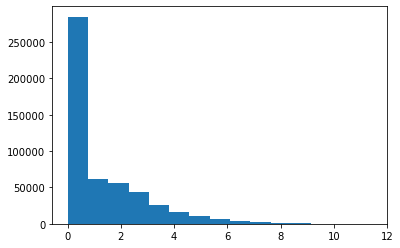

In [13]:
# Посмотрим гистограмму частоты встречаемости артистов

def get_freq_list(data):
    counter = Counter()
    for session in data:
        for item in session:
            counter[item] += 1
    return [math.log(v) for _, v in counter.items()], counter

artist_sessions = np.asarray(artist_sessions)
artist_freq_list, artist_counter = get_freq_list(artist_sessions[:, 2])
_ = plt.hist(artist_freq_list, bins=15)
len(artist_sessions)

(1710615, 15496)

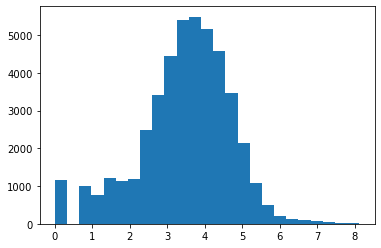

In [14]:
counter = Counter()
# Частота встречаемости пользователей в сессиях
for uid, _, _ in artist_sessions:
    counter[uid] += 1
freq = [v for _,v in counter.items()]
_ = plt.hist(list(map(lambda x: math.log(x),freq)), bins=25)

artist_sessions = list(filter(lambda x: math.log(counter[x[0]]) > 4 and math.log(counter[x[0]]) < 6, artist_sessions))
user_set = set()
for uid, _, _ in artist_sessions:
    user_set.add(uid)
# всего сессий и всего уникальных пользователей
len(artist_sessions), len(user_set)

89729

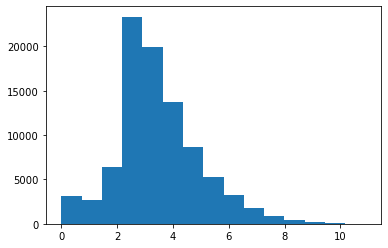

In [15]:
# Отфильтруем артистов, которые встречаются в сессиях слишком редко
filtered_sessions = []
for session in artist_sessions:
    uid, timestamp, artists = session
    artists = list(filter(lambda artist: math.log(artist_counter[artist]) > 2.5, artists))
    if len(artists) > 0:
        filtered_sessions.append((uid, timestamp, artists))

artist_sessions = np.asarray(filtered_sessions)
artist_freq_list, artist_counter = get_freq_list(artist_sessions[:, 2])
# Частота встречаемости артистов в сессиях
_ = plt.hist(artist_freq_list, bins=15)
# Всего артистов
len(artist_counter)

In [16]:
# Сохраним данные для Item2Vec модели
# Для ALS и NeuMF понадобится ещё сделать flatten, чтобы получить записи User;Timestamp;Artist
pickle.dump(artist_sessions, open('../preprocessed_data/user_timestamp_[artists].pckl', 'wb'))

positive_samples = []
# Представляем все сессии в виде User;Timestamp;Artist
for session in tqdm(artist_sessions):
    uid, timestamp, artists = session
    session = [(uid, timestamp, artist) for artist in artists]
    positive_samples.extend(session)

100%|████████████████████████████████████████████████████████████████████| 1325347/1325347 [00:05<00:00, 223860.86it/s]


In [17]:
# Позитивные сэмплы готовы для передачи в модели
# Для ALS негативные сэмплы создавать не нужно, тк он сам построит матрицу взаимодействий, и сам будет знать что пользователь "не оценивал"
# Для NeuMF и UserNeuMF нужно будет явно создать негативные сэмплы и добавить их в датасет
# Но для начала разделим данные на train и test согласно timestamp'у

In [13]:
# Обработка лайков
likes_list = pickle.load(open('../preprocessed_data/likes_list.pckl', 'rb'))
track_list = pickle.load(open('../preprocessed_data/track_list.pckl', 'rb'))
track_to_artist = dict(map(lambda x: (x[0], x[1]), track_list))
likes_list = np.asarray(likes_list)[:, :2]
likes_list[0]

array([  44542, 2785601])

In [15]:
likes_counter = Counter()
for uid, track_id in likes_list:
    artist_id = track_to_artist[track_id]
    pair = (uid, artist_id)
    likes_counter[pair] += 1

In [16]:
len(likes_counter)

873284

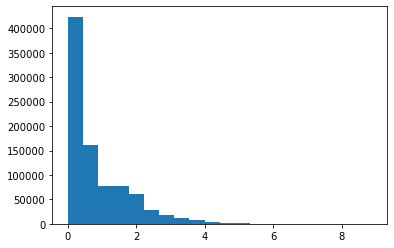

In [18]:
freq = [math.log(v) for _, v in likes_counter.items()]
# Распределение количества лайков на пары (user, artist)
_ = plt.hist(freq, bins=20)

In [19]:
pickle.dump(likes_counter, open('../preprocessed_data/likes_counter.pckl', 'wb'))

## Train-test-split и выбор метрик

In [18]:
positive_dataset = pd.DataFrame(positive_samples, columns=['uid', 'timestamp', 'artist'])

In [19]:
# Идея разбиения на timestamp - каждому timestamp'у даём некоторый ранг, в пределах от 0 до 1. Всё что ниже 0.9 - train data, выше - test
ranks = positive_dataset.groupby('uid')['timestamp'].rank(method='first')
counts = positive_dataset['uid'].map(positive_dataset.groupby('uid')['timestamp'].apply(len))
result = (ranks / counts) > 0.8

In [20]:
result.describe()

count     14842554
unique           2
top          False
freq      11867793
dtype: object

In [21]:
test_data, train_data = set(), set()
splitter = result.values
for i, sample in enumerate(positive_samples, 0):
    uid, artist = sample[0], sample[2]
    if splitter[i] == True:
        test_data.add((uid, artist))
    else:
        train_data.add((uid, artist))

In [22]:
len(train_data), len(test_data)

(2405220, 848790)

In [23]:
# Теперь, когда тестовая и обучающая выборки готовы - выбор метрик
# В качестве метрик я выбрал Hit Rate at K и Normalized Discounted Cumulative Gain at K
# Когда нужно будет вычислять точность модели, для каждого пользователя из тестовой выборки мы предскажем top-K рекомендаций
# И проверим, на сколько совпало с реальными данными в тестовом датасете 
# мы поделили его по timestamp'у, поэтому можно сказать, что модель должна предсказать интерес пользователя, и мы проверим, как хорошо она справилась

In [24]:
pickle.dump(train_data, open('../preprocessed_data/train_data.pckl', 'wb'))
pickle.dump(test_data, open('../preprocessed_data/test_data.pckl', 'wb'))

### Baseline - Spark ALS

In [5]:
train_data = pickle.load(open('../preprocessed_data/train_data.pckl', 'rb'))
test_data = pickle.load(open('../preprocessed_data/test_data.pckl', 'rb'))
negative_samples = flood_negative_samples(train_data, test_data)

In [6]:
train_data = list(map(lambda x: (x[0], x[1], 1), train_data))
negative_samples = list(map(lambda x: (x[0], x[1], 0), negative_samples))
train_data.extend(negative_samples)

In [7]:
schema = StructType([StructField('user', IntegerType()), StructField('item', IntegerType()), StructField('rating', IntegerType())])
spark_train_rdd = sc.parallelize(train_data)
spark_train_df = spark.createDataFrame(spark_train_rdd, schema)
spark_test_rdd = sc.parallelize(list(map(lambda x: (x[0], x[1], 1),train_data)))
spark_test_df = spark.createDataFrame(spark_test_rdd, schema)

In [8]:
user_artist_test_dict = spark_test_df.select(['user', 'item']) \
                                    .rdd.map(lambda x: (x['user'], x['item'])) \
                                    .groupByKey() \
                                    .collectAsMap()

In [9]:
maxIter=20
regParam=1
rank=10
topK = 100

In [14]:
als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, coldStartStrategy='drop')
als_model = als.fit(spark_train_df)

In [11]:
def evaluate_als(als_model, test_df, user_artist_test_dict):
    recommendations = als_model.recommendForUserSubset(test_df.select(['user']), topK).collect()
    print('recs are ready')
    ndcg_scores = []
    hr_scores = []
    step = 0
    for user, rec in recommendations:
        real_items = list(user_artist_test_dict[user])
        pred_items = [item[0] for item in rec]
        pred_scores = [item[1] for item in rec]
        ndcg_score = ndcg(real_items, pred_items, pred_scores)
        hr_score = hr(real_items, pred_items)
        ndcg_scores.append(ndcg_score)
        hr_scores.append(hr_score)
    return np.mean(hr_scores), np.mean(ndcg_scores)

In [15]:
evaluate_als(als_model, spark_test_df, user_artist_test_dict)

recs are ready


(0.0009764050806849709, 0.0008475165070758779)

## Использование явных рейтингов в Spark ALS

In [4]:
likes_counter = pickle.load(open('../preprocessed_data/likes_counter.pckl', 'rb'))
likes_data = list(map(lambda k: (int(k[0][0]), int(k[0][1]), int(k[1])), likes_counter.items()))

In [5]:
schema = StructType([StructField('user', IntegerType()), StructField('item', IntegerType()), StructField('rating', IntegerType())])
spark_likes_rdd = sc.parallelize(likes_data)
spark_likes_df = spark.createDataFrame(spark_likes_rdd, schema)

In [6]:
spark_likes_train, spark_likes_test = spark_likes_df.randomSplit([0.8, 0.2])

In [7]:
user_artist_test_dict = spark_likes_test.select(['user', 'item']) \
                                    .rdd.map(lambda x: (x['user'], x['item'])) \
                                    .groupByKey() \
                                    .collectAsMap()

In [13]:
maxIter=20
regParam=0.1
rank=10
topK = 100

In [15]:
als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, coldStartStrategy='drop')
als_model = als.fit(spark_likes_train)

In [21]:
evaluate_als(als_model, spark_likes_test, user_artist_test_dict)

recs are ready


(0.00589700553034128, 0.0017013129282348347)

# NeuMF

In [2]:
train_data = pickle.load(open('../preprocessed_data/train_data.pckl', 'rb'))
validation_data = pickle.load(open('../preprocessed_data/test_data.pckl', 'rb'))
# Нужно создать негативные сэмплы для датасета. число 150 выбрано, чтобы создать негативные сэмплы примерно 1:1 с позитивными
negative_samples = flood_negative_samples(train_data, validation_data, samples_per_user=150)

In [3]:
# torch.nn.Embedding работает как таблица и требует, чтобы индексы были в границах [0; Длина словаря]
# У нас длина словаря соответственно это количество пользователей и артистов
user_mapper, item_mapper = ItemDataset.get_mappers(train_data.union(validation_data))
# Позитивные сэмплы теперь будут иметь отметку 1
train_data = list(map(lambda x: (x[0], x[1], 1), train_data))
# Нетивные соответсвенно 0
negative_samples = list(map(lambda x: (x[0], x[1], 0), negative_samples))
# Нужно слить данные и поделить на тестовую и обучающую выборку
train_data.extend(negative_samples)
train, test = train_test_split(train_data, train_size=0.8)

train_dataset = ItemDataset(train, user_mapper, item_mapper)
test_dataset = ItemDataset(test, user_mapper, item_mapper)
# Датасет для валидации на метриках HR@20 и NDCG@20
validation_dataset = ValidationDataset(validation_data, user_mapper, item_mapper)
BATCH_SIZE = 8192
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████████████████████████████████████████████████████████████████| 848790/848790 [00:01<00:00, 643541.29it/s]


In [4]:
# Соответственно размеры словарей для эмбеддингов
len(user_mapper), len(item_mapper)

(15495, 89729)

In [4]:
config = Hparam('config.yaml')
gmf_model = GMF(config.gmf)
mlp_model = MLP(config.mlp)
a, b = [torch.zeros((1024)).long() for _ in range(2)]
_ = summary(gmf_model, a, b)
_ = summary(mlp_model, a, b)

                  Kernel Shape Output Shape   Params Mult-Adds
Layer                                                         
0_user_embeddings  [10, 15495]   [1024, 10]  154.95k   154.95k
1_item_embeddings  [10, 89729]   [1024, 10]  897.29k   897.29k
2_out.Linear_0         [10, 1]    [1024, 1]     11.0      10.0
3_out.Sigmoid_1              -    [1024, 1]        -         -
----------------------------------------------------------------
                         Totals
Total params          1.052251M
Trainable params      1.052251M
Non-trainable params        0.0
Mult-Adds              1.05225M
                        Kernel Shape Output Shape      Params   Mult-Adds
Layer                                                                    
0_user_embeddings       [128, 15495]  [1024, 128]    1.98336M    1.98336M
1_item_embeddings       [128, 89729]  [1024, 128]  11.485312M  11.485312M
2_hidden.Linear_0         [256, 128]  [1024, 128]     32.896k     32.768k
3_hidden.LeakyReLU_1       

In [6]:
writer = SummaryWriter()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gmf_model.to(device)
mlp_model.to(device)
# Как оптимизатор выбран SGD, тк остальные оптимизаторы используют momentum и сохраняют о нём информацию, а тк NeuMF будем дообучать после соединения моделей
# Эта информация будет утеряна и он будет хуже обучаться
gmf_optim = torch.optim.SGD(gmf_model.parameters(), lr=0.05)
mlp_optim = torch.optim.SGD(mlp_model.parameters(), lr=0.05)
criterion = nn.BCELoss()

In [11]:
# Обучаем GMF и MLP соответственно
train_ncf(gmf_model, train_loader, test_loader, validation_dataset, gmf_optim, criterion, device, writer, config.train_gmf)
train_ncf(mlp_model, train_loader, test_loader, validation_dataset, mlp_optim, criterion, device, writer, config.train_mlp)

start training


<div>
    <img src="pics\gmf_test_loss.png" width="200" height="200">
    <img src="pics\gmf_train_loss.png" width="200" height="200">
</div>
<div>
    <img src="pics\mlp_test_loss.png" width="200" height="200">
    <img src="pics\mlp_train_loss.png" width="200" height="200">
</div>

In [7]:
# Соединяем обученые GMF и MLP в NeuMF
gmf_path = os.path.join(config.train_gmf.save_path, 'epoch_20.ckpt')
mlp_path = os.path.join(config.train_mlp.save_path, 'epoch_20.ckpt')
neu_mf = load_pretrained_weights_neu_mf_from_path(gmf_path, config.gmf, mlp_path, config.mlp, config.neu_mf)

In [8]:
neu_mf.to(device)
# Уже для NeuMF можно использовать любой оптимизатор - никаких ограничений нет
neu_mf_optim = torch.optim.Adam(neu_mf.parameters())

In [10]:
train_ncf(neu_mf, train_loader, test_loader, validation_dataset, neu_mf_optim, criterion, device, writer, config.train_neu)
# В итоге по графику test loss'a можно увидеть, что модель начала оверфититься около 1.5к итераций - 5 эпоха
# При этом трейн падает, поэтому это точно уже оверфит
# Поэтому для вычисления метрик можно взять 4 чекпоинт модели

start training


<div>
    <img src="pics\neu_mf_test_loss.png" width="200" height="200">
    <img src="pics\neu_mf_train_loss.png" width="200" height="200">
</div>

In [7]:
neu_mf = NeuMF(config.neu_mf)
neu_mf.load_state_dict(torch.load('../model_checkpoints/NCF/NEU/epoch_4.ckpt'))
neu_mf.to(device)
evaluate_neu(neu_mf, validation_dataset, device, writer, config.train_neu)

<div>
    <img src="pics\neu_mf_hr.png" width="200" height="200">
    <img src="pics\neu_mf_ndcg.png" width="200" height="200">
</div>

В итоге с тензоборда можно получить значения:
* HR@20 (Max) = 0.7
* NDCG@20 (MAX) = 0.771
* HR@20 (Mean) = 0.101
* NDCG@20 (Mean) = 0.109

## NeuMF with User Info

In [2]:
# Этот подход будет отличаться только тем, что в MLP модель мы будем добавлять
# Фичи связанные с пользователем - возраст, гендер - 0 и 1 (их всего два), id страны, и нормализованное количество прослушиваний
# Плюс, как эксперимент, будем пробовать обучать сразу UserNeuMF
user_list = pickle.load(open('../preprocessed_data/user_list.pckl', 'rb'))
user_features = ItemDataset.user_info_preprocessed(user_list)

In [21]:
train_data = pickle.load(open('../preprocessed_data/train_data.pckl', 'rb'))
validation_data = pickle.load(open('../preprocessed_data/test_data.pckl', 'rb'))
# negative_samples = flood_negative_samples(train_data, validation_data, samples_per_user=150)

In [22]:
# Шаги все те же, что и для NeuMF, только в датасеты ещё передаём фичи пользователя
user_mapper, item_mapper = ItemDataset.get_mappers(train_data.union(validation_data))
train_data = list(map(lambda x: (x[0], x[1], 1), train_data))
negative_samples = list(map(lambda x: (x[0], x[1], 0), negative_samples))
train_data.extend(negative_samples)

train, test = train_test_split(train_data, train_size=0.8)

train_dataset = ItemDataset(train, user_mapper, item_mapper, user_features)
test_dataset = ItemDataset(test, user_mapper, item_mapper, user_features)

validation_dataset = ValidationDataset(validation_data, user_mapper, item_mapper, user_features)

BATCH_SIZE = 8192
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [2]:
config = Hparam('config.yaml')
user_neu_mf = UserNeuMF(config.neu_mf)
a, b = [torch.zeros((1024)).long() for _ in range(2)]
c = torch.zeros((1024, 4))
_ = summary(user_neu_mf, a, b, c)

                        Kernel Shape Output Shape      Params   Mult-Adds
Layer                                                                    
0_user_embeddings_mf     [10, 15495]   [1024, 10]     154.95k     154.95k
1_item_embeddings_mf     [10, 89729]   [1024, 10]     897.29k     897.29k
2_user_embeddings_mlp   [128, 15495]  [1024, 128]    1.98336M    1.98336M
3_item_embeddings_mlp   [128, 89729]  [1024, 128]  11.485312M  11.485312M
4_hidden.Linear_0         [260, 128]  [1024, 128]     33.408k      33.28k
5_hidden.LeakyReLU_1               -  [1024, 128]           -           -
6_hidden.Dropout_2                 -  [1024, 128]           -           -
7_hidden.Linear_3          [128, 64]   [1024, 64]      8.256k      8.192k
8_hidden.LeakyReLU_4               -   [1024, 64]           -           -
9_hidden.Dropout_5                 -   [1024, 64]           -           -
10_hidden.Linear_6          [64, 32]   [1024, 32]       2.08k      2.048k
11_hidden.LeakyReLU_7              -  

In [6]:
writer = SummaryWriter()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
user_neu_mf.to(device)
# Ограничений нет, можем использовать любой оптимизатор
user_neu_mf_optim = torch.optim.Adam(user_neu_mf.parameters())
criterion = nn.BCELoss()

In [29]:
train_user_neu(user_neu_mf, train_loader, test_loader, validation_dataset, user_neu_mf_optim, criterion, device, writer, config.train_neu)
# UserNeuMF постигла участь NeuMF и он заоверфитился после 7 эпохи

start training


In [6]:
user_neu_mf.load_state_dict(torch.load('../model_checkpoints/NCF/NEUUSR/epoch_5.ckpt'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
user_neu_mf.to(device)
writer = SummaryWriter()
evaluate_user_neu(user_neu_mf, validation_dataset, device, writer, config.train_neu)

В итоге с тензоборда можно получить значения:
* HR@20 (Max) = 0.65
* NDCG@20 (MAX) = 0.6747
* HR@20 (Mean) = 0.09244
* NDCG@20 (Mean) = 0.1045

## Сравнение моделей и предсказание артистов

В сравнении между

In [35]:
artists_list = pickle.load(open('../preprocessed_data/artist_list.pckl', 'rb'))

In [39]:
artists_map = dict(artists_list)

In [20]:
user_neu_mf.to(torch.device('cpu'))
artists = torch.stack([torch.tensor(i).long() for i in range(config.train_neu.item_count)])
embeddings = user_neu_mf.item_embeddings_mf(artists)
embeddings = [i.detach().numpy() for i in embeddings]
nearest_neib = NearestNeighbors().fit(embeddings)

In [33]:
artist_mapper = {v:k for k,v in item_mapper.items()}
# Найдём исполнителей, похожих на Travis Scott
Travis_Idx = item_mapper[287560]
travis_embedding = embeddings[Travis_Idx]
prediction = nearest_neib.kneighbors([travis_embedding], n_neighbors=20, return_distance=False)[0]

In [42]:
for idx in prediction:
    artist_id = artist_mapper[idx]
    print(list(artists_map[artist_id])[0][0])

Rammstien
The+Mouse+Outfit
Noah+Howard+Group
Zilch
Giacinto+Scelsi
Capricorn
Hatifnats
Southern+Culture+On+The+Skids
Clever+Girl
Klaus+Badelt
Klaus+Sch%C3%B8nning
Thelonious+Monk+&+John+Coltrane
TeV95
Sterling+Holloway
Mainstay
Death+Wolf
Shook
Fredo+Viola
Die+Streuner
The+Soundtrack+Tribute+Band
